In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

1. Use `torchvision` to implement random cropping of the data. <br>

    1. How are the resulting images different from the uncropped originals? <br>
        As one would imagine, the resulting image are cropped randomly based on the size. <br>
        Images are smaller too. I used size 20. If I chose the same size (32), there's no cropping. <br><br>

    2. What happens when you request the same image a second time? <br>
        Everytime the cropping is different <br><br>

    3. What is the result of training using randomly cropped images? <br>
        It's hard to understand as we are printing losses of the last batch in each epoch.<br>
        Intuitively, our model should generalize more because in each epoch, the crop will be different <br>
        and hence, same image will have the object (bird, plane) in spatially different places. This will <br>
        result in less chances of overfitting <br><br>
        

2. Switch loss functions (perhaps MSE). <br>

    1. Does the training behavior change? <br>
        We have to one hot encode the labels as mentioned in the book <br><br>

    2. Is it possible to reduce the capacity of the network enough that it stops overfitting? <br>
        Yet to try with smaller networks

    3. How does the model perform on the validation set when doing so? <br>
        Almost similar performance, although the performance oscillates up and down instead of smooth one direction

In [24]:
data_path = '../data/p1ch7/'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(20)
    ])
)

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(20)
    ])
)

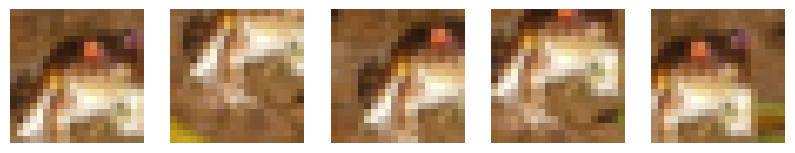

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(10, 50))

for i in range(5):
    img, _ = cifar10[0]
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].axis('off');

In [50]:
label_map = {0: 0, 2: 1}

cifar2 = [(img, torch.tensor(label_map[label])) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, torch.tensor(label_map[label])) for img, label in cifar10_val if label in [0, 2]]

trainloader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [51]:
img, label = cifar2[0]
label

tensor(1)

In [74]:
model = nn.Sequential(
    nn.Linear(3*20*20, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 2)
)

lr = 1e-2
n_epochs = 500
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()


In [75]:
train_acc, val_acc = [], []

for epoch in range(n_epochs):
    train_corr, train_tot = 0, 0
    val_corr, val_tot = 0, 0
    
    losses = []

    for imgs, labels in trainloader:
        out = model(imgs.view(imgs.shape[0], -1))

        
        loss = loss_fn(out, labels)
        losses.append(loss.detach().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs, labels in trainloader:
            out = model(imgs.view(imgs.shape[0], -1))
            _, predicted = torch.max(out, dim=1)

            train_corr += int((predicted==labels).sum())
            train_tot += labels.shape[0]
    
    with torch.no_grad():
        for imgs, labels in valloader:
            out = model(imgs.view(imgs.shape[0], -1))
            _, predicted = torch.max(out, dim=1)

            val_corr += int((predicted==labels).sum())
            val_tot += labels.shape[0]
    
    train_acc.append(train_corr/train_tot)
    val_acc.append(val_corr/val_tot)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} \t Loss: {loss.mean():.4f} \t Train Acc:{train_acc[epoch]} \t Val Acc: {val_acc[epoch]}')

Epoch: 0 	 Loss: 0.6093 	 Train Acc:0.6855 	 Val Acc: 0.6865


KeyboardInterrupt: 

In [ ]:
loss_fn = nn.MSELoss()

train_acc, val_acc = [], []

for epoch in range(n_epochs):
    train_corr, train_tot = 0, 0
    val_corr, val_tot = 0, 0
    
    losses = []

    for imgs, labels in trainloader:
        out = model(imgs.view(imgs.shape[0], -1))

        label_onehot = torch.zeros(labels.shape[0], 2)
        label_onehot.scatter_(1, labels.unsqueeze(1), 1.0)
        
        loss = loss_fn(out, label_onehot)
        losses.append(loss.detach().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs, labels in trainloader:
            out = model(imgs.view(imgs.shape[0], -1))
            _, predicted = torch.max(out, dim=1)

            train_corr += int((predicted==labels).sum())
            train_tot += labels.shape[0]
    
    with torch.no_grad():
        for imgs, labels in valloader:
            out = model(imgs.view(imgs.shape[0], -1))
            _, predicted = torch.max(out, dim=1)

            val_corr += int((predicted==labels).sum())
            val_tot += labels.shape[0]
    
    train_acc.append(train_corr/train_tot)
    val_acc.append(val_corr/val_tot)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} \t Loss: {loss.mean():.4f} \t Train Acc:{train_acc[epoch]} \t Val Acc: {val_acc[epoch]}')

Epoch: 0 	 Loss: 0.3206 	 Train Acc:0.7644 	 Val Acc: 0.7595
Epoch: 1 	 Loss: 0.1687 	 Train Acc:0.7442 	 Val Acc: 0.7385
Epoch: 2 	 Loss: 0.1764 	 Train Acc:0.7748 	 Val Acc: 0.7735
Epoch: 3 	 Loss: 0.2283 	 Train Acc:0.7479 	 Val Acc: 0.7405
Epoch: 4 	 Loss: 0.1975 	 Train Acc:0.6051 	 Val Acc: 0.612
Epoch: 5 	 Loss: 0.1639 	 Train Acc:0.7742 	 Val Acc: 0.7655
Epoch: 6 	 Loss: 0.1298 	 Train Acc:0.7743 	 Val Acc: 0.766
Epoch: 7 	 Loss: 0.0905 	 Train Acc:0.7755 	 Val Acc: 0.7775
Epoch: 8 	 Loss: 0.1539 	 Train Acc:0.7757 	 Val Acc: 0.7785
Epoch: 9 	 Loss: 0.1825 	 Train Acc:0.7591 	 Val Acc: 0.748
Epoch: 10 	 Loss: 0.1915 	 Train Acc:0.7239 	 Val Acc: 0.7215
Epoch: 11 	 Loss: 0.1938 	 Train Acc:0.7076 	 Val Acc: 0.7055
Epoch: 12 	 Loss: 0.1679 	 Train Acc:0.7796 	 Val Acc: 0.7795
Epoch: 13 	 Loss: 0.1332 	 Train Acc:0.7652 	 Val Acc: 0.759
Epoch: 14 	 Loss: 0.1405 	 Train Acc:0.7697 	 Val Acc: 0.7575
